# 라이브러리 불러오기

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

/Users/t2023-m0093/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
data = pd.read_csv(url)

- sqlite database에 저장할 땐 connect 하고 db 명을 적어준다.
- daily_temperature라는 db에 temperatures라는 테이블로 저장한다.
- 만약 temperatures라는 테이블이 있으면 replace 해줘.

In [3]:
conn = sqlite3.connect('daily_temperature.db')
data.to_sql('temperatures',conn,if_exists = 'replace',index = False)

3650

# 데이터 전처리 및 추출

In [4]:
yearly_max_temp_query = """
select strftime('%Y',Date) as Year,
       max(Temp) as MaxTemp
from temperatures
group by Year
order by Year;
"""
# 쿼리를 적고 판다스를 이용해서 바로 dataframe으로 가져올 수 있다.
yearly_max_temp = pd.read_sql_query(yearly_max_temp_query,conn)
yearly_max_temp
# 각 연도의 최고 기온을 보여줌.

,Year,MaxTemp
0,1981,25.0
1,1982,26.3
2,1983,22.5
3,1984,24.3
4,1985,22.4
5,1986,21.4
6,1987,24.1
7,1988,23.9
8,1989,22.0
9,1990,22.1


# 데이터 시각화 : 연도별 최대 기온

In [5]:
from matplotlib import rc
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

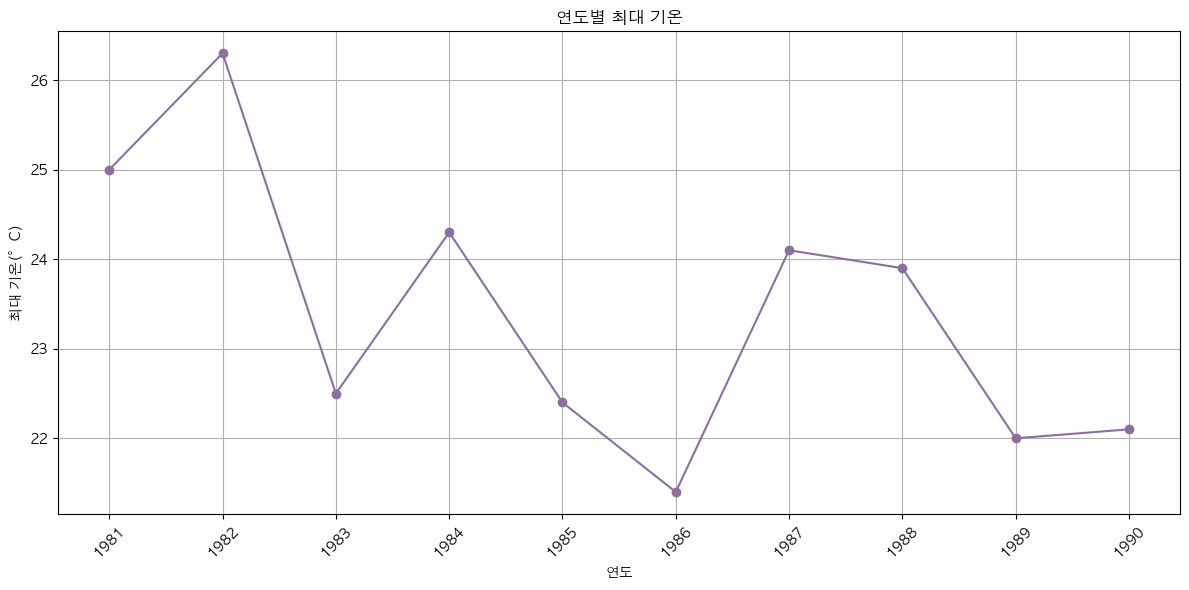

In [6]:
plt.figure(figsize=(12,6))

plt.plot(yearly_max_temp['Year'],yearly_max_temp['MaxTemp'],
         marker = 'o',
         linestyle = '-',
         color = '#8c6f9e')

plt.title('연도별 최대 기온')
plt.xlabel('연도')
plt.ylabel('최대 기온(°C)')

plt.xticks(rotation=45)
plt.grid(True)

# 그래프의 레이아웃을 자동으로 조정한다. 축과 라벨이 그래프 영역에 잘 들어맞게 한다.
plt.tight_layout()

plt.show()

# SQL 쿼리 실행 : 월별 평균 기온 계산

In [9]:
monthly_avg_temp_query = """
select strftime('%Y-%m',Date) as YearMonth,
       avg(Temp) as AvgTemp
from temperatures
group by YearMonth
order by YearMonth
"""

monthly_avg_temp = pd.read_sql_query(monthly_avg_temp_query,conn)
monthly_avg_temp

,YearMonth,AvgTemp
0,1981-01,17.712903
1,1981-02,17.678571
2,1981-03,13.500000
3,1981-04,12.356667
4,1981-05,9.490323
...,...,...
115,1990-08,7.825806
116,1990-09,9.166667
117,1990-10,11.345161
118,1990-11,12.656667


# 월별 평균 기온 시각화

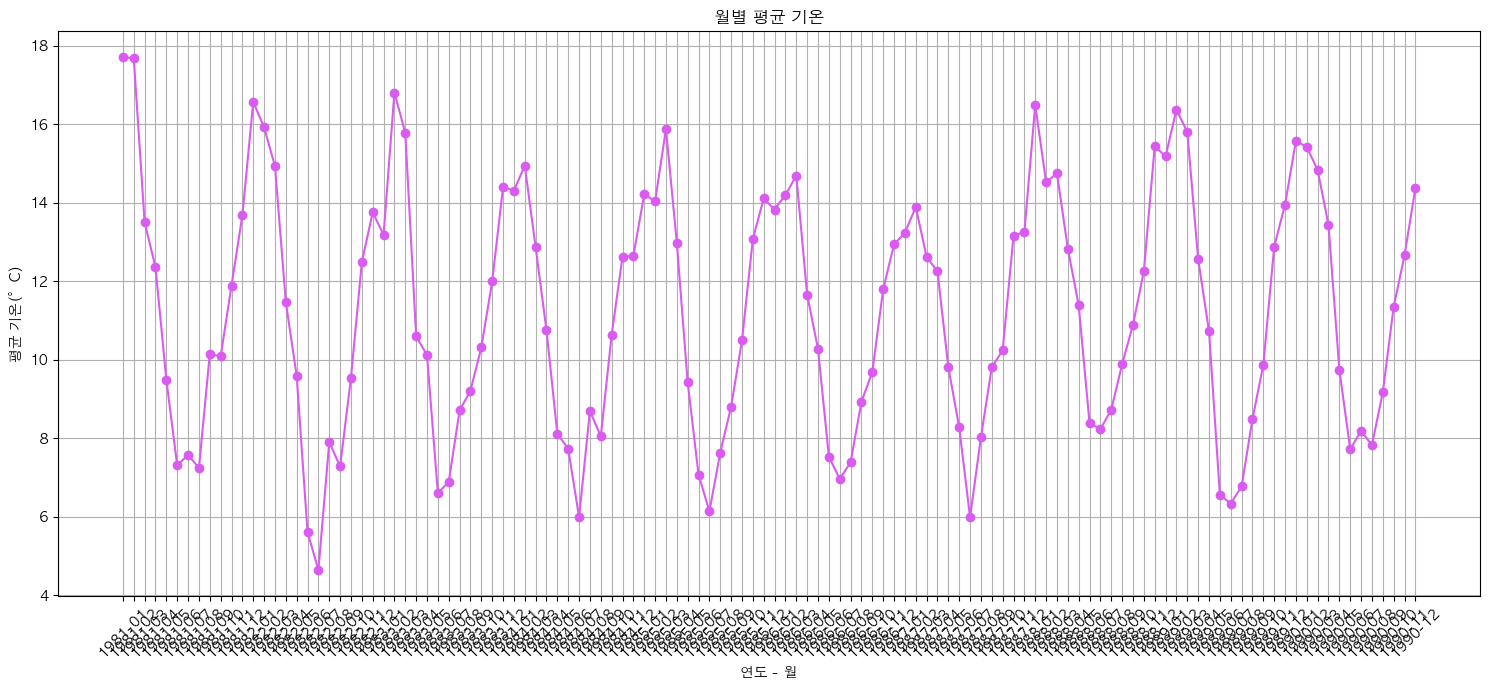

In [10]:
plt.figure(figsize=(15,7))
plt.plot(monthly_avg_temp['YearMonth'],
         monthly_avg_temp['AvgTemp'],
         marker = 'o',
         linestyle = '-',
         color = '#d95bf0')

plt.title('월별 평균 기온')

plt.xlabel('연도 - 월')
plt.ylabel('평균 기온(°C)')

plt.xticks(rotation=45)

plt.grid(True)

plt.tight_layout()
plt.show()
# Year_Month가 str형태기 때문에 모두 겹쳐서 표시됨.

# pd.to_datetime

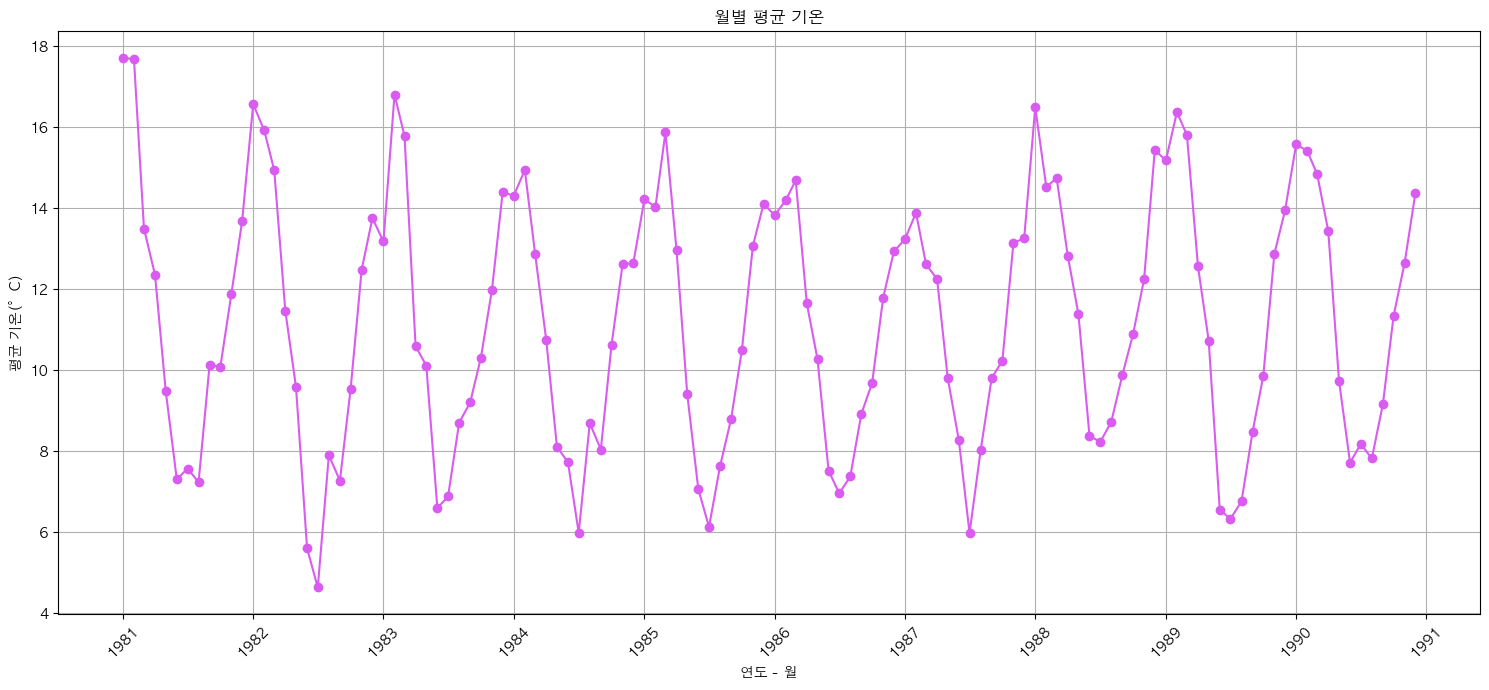

In [11]:
plt.figure(figsize=(15,7))
plt.plot(pd.to_datetime(monthly_avg_temp['YearMonth']),
         monthly_avg_temp['AvgTemp'],
         marker = 'o',
         linestyle = '-',
         color = '#d95bf0')

plt.title('월별 평균 기온')

plt.xlabel('연도 - 월')
plt.ylabel('평균 기온(°C)')

plt.xticks(rotation=45)

plt.grid(True)

plt.tight_layout()
plt.show()

# 변동성 분석

In [12]:
query = """
select Date,
       abs(Temp - LAG(Temp,1) over (order by Date)) as DailyChange
from temperatures;
"""

daily_change = pd.read_sql_query(query,conn)
daily_change

,Date,DailyChange
0,1981-01-01,NaN
1,1981-01-02,2.8
2,1981-01-03,0.9
3,1981-01-04,4.2
4,1981-01-05,1.2
...,...,...
3645,1990-12-27,0.6
3646,1990-12-28,0.4
3647,1990-12-29,0.1
3648,1990-12-30,2.2


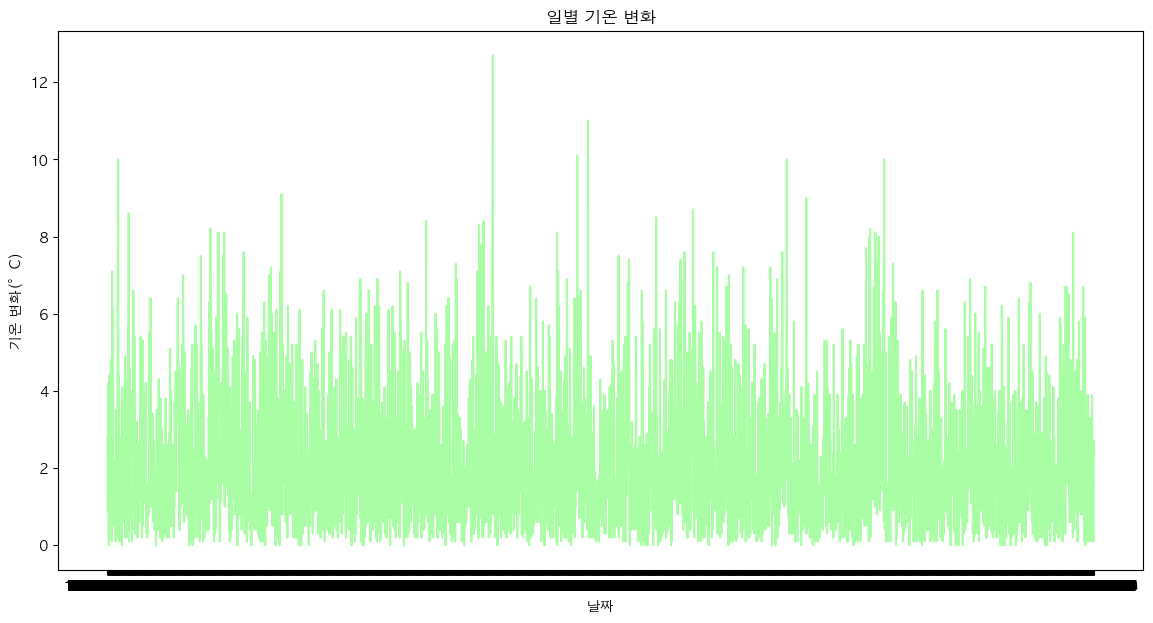

In [13]:
plt.figure(figsize=(14,7))
plt.plot(daily_change['Date'],
         daily_change['DailyChange'],
         color = '#52fc4c', alpha = 0.5)

plt.title('일별 기온 변화')
plt.xlabel('날짜')
plt.ylabel('기온 변화(°C)')

plt.show()

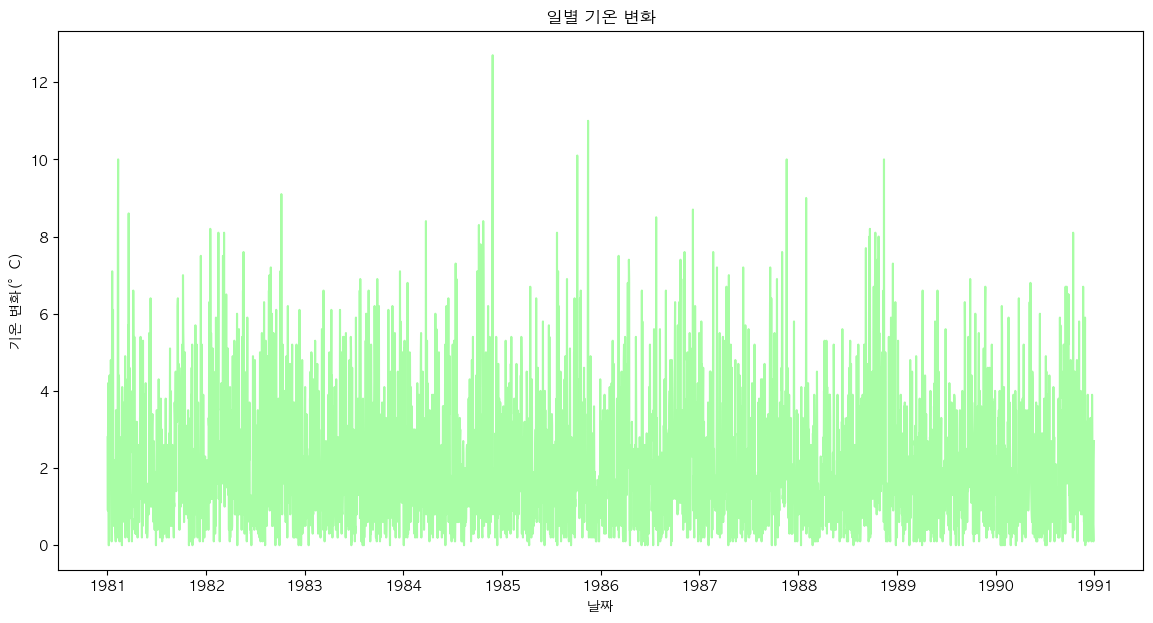

In [14]:
plt.figure(figsize=(14,7))
plt.plot(pd.to_datetime(daily_change['Date']),
         daily_change['DailyChange'],
         color = '#52fc4c', alpha = 0.5)

plt.title('일별 기온 변화')
plt.xlabel('날짜')
plt.ylabel('기온 변화(°C)')

plt.show()

# 자기상관성 분석

In [15]:
import numpy as np

query = """
select Date,
       temp as Temperature,
       LAG(Temp,1) over (order by Date) as PrevDayTemp
from temperatures
"""

temp_data = pd.read_sql_query(query,conn)
temp_data

,Date,Temperature,PrevDayTemp
0,1981-01-01,20.7,NaN
1,1981-01-02,17.9,20.7
2,1981-01-03,18.8,17.9
3,1981-01-04,14.6,18.8
4,1981-01-05,15.8,14.6
...,...,...,...
3645,1990-12-27,14.0,14.6
3646,1990-12-28,13.6,14.0
3647,1990-12-29,13.5,13.6
3648,1990-12-30,15.7,13.5


In [16]:
# 결측값을 제거한다.
temp_data.dropna(inplace=True)

temp_data['TempChange'] = temp_data['Temperature'] - temp_data['PrevDayTemp']
temp_data

,Date,Temperature,PrevDayTemp,TempChange
1,1981-01-02,17.9,20.7,-2.8
2,1981-01-03,18.8,17.9,0.9
3,1981-01-04,14.6,18.8,-4.2
4,1981-01-05,15.8,14.6,1.2
5,1981-01-06,15.8,15.8,0.0
...,...,...,...,...
3645,1990-12-27,14.0,14.6,-0.6
3646,1990-12-28,13.6,14.0,-0.4
3647,1990-12-29,13.5,13.6,-0.1
3648,1990-12-30,15.7,13.5,2.2


In [17]:
# numpy의 corrcoef : 온도 변화량의 1일 시차 자기상관 계수를 계산한다.
# 시간에 따른 연속된 데이터 포인트 간의 상관관계를 나타냄.
correlation = np.corrcoef(temp_data['TempChange'][1:],
                          temp_data['TempChange'][:-1])[0,1]

print(f"1일 시차 기온 변화의 자기상관 계수: {correlation:.2f}")

1일 시차 기온 변화의 자기상관 계수: -0.18


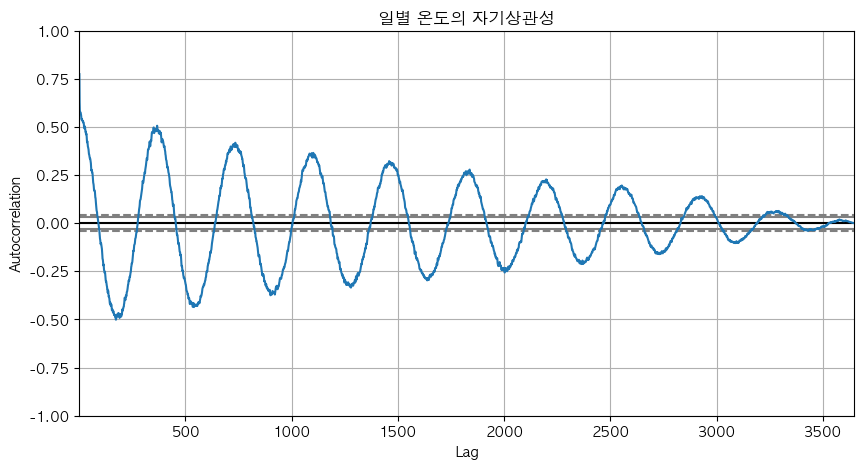

In [19]:
plt.figure(figsize=(10,5))
pd.plotting.autocorrelation_plot(temp_data['Temperature'])
plt.title('일별 온도의 자기상관성')
plt.show()

# 데이터베이스 연결 닫기

In [20]:
conn.close()